In [61]:
!pip install earthpy gdal

# importing the necessary libraries
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore') # allow deviding by zero

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [62]:
#working with images from Sentinel-2 (MS-12 bands)
#add file names into a glob list
S_sentinel_bands = glob("//content/*B?*.tiff")
S_sentinel_bands.sort()
S_sentinel_bands

['//content/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '//content/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '//content/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '//content/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '//content/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '//content/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '//content/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 '//content/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 '//content/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 '//content/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B11_(Raw).tiff',
 '//content/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B12_(Raw).tiff',
 '//content/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B8A_(Raw).tiff']

In [80]:
#appending the tiff images into a list
l = []
S_sentinel_bands = S_sentinel_bands[0:]
for i in S_sentinel_bands:
  with rio.open(i, 'r') as f:
    l.append(f.read(1)) #reading the first band from the tiff image (this tiff actually has only 1 band anyways)


In [81]:
#stacking all images into one numpy array
arr_st = np.stack(l)

#print the x,y and number of bands
print(f'Height: {arr_st.shape[1]}\nWidth: {arr_st.shape[2]}\nBands: {arr_st.shape[0]}')



Height: 954
Width: 298
Bands: 12


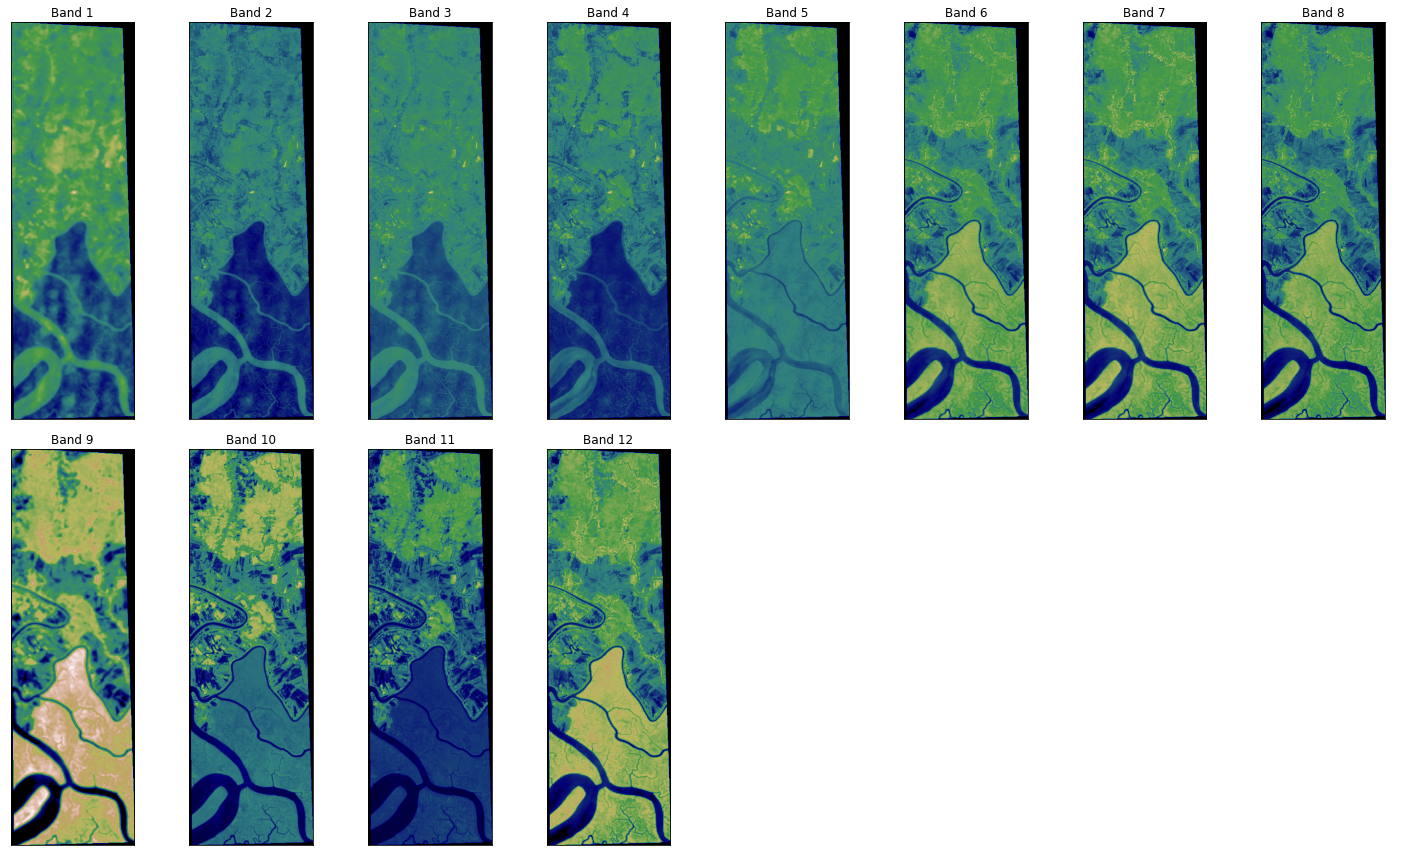

In [82]:
# Visualizing the different bands
ep.plot_bands(arr_st, cmap = 'gist_earth', figsize = (20, 12), cols = 8, cbar = False)
plt.show()



In [83]:
print("Bands axis is in the wrong place:", arr_st.shape) # As you can see the bands axis is in the wrond place

#Preparing the data, moving the bands axis to the correct place
#arr_st = arr_st[0:100,0:100 ,:]
x = np.moveaxis(arr_st, 0, -1)
print("This is the correct order:", x.shape)


Bands axis is in the wrong place: (12, 954, 298)
This is the correct order: (954, 298, 12)


In [84]:
#Preparing the train data set

from sklearn.preprocessing import StandardScaler

X_data = x.reshape(-1,12)

scaler = StandardScaler().fit(X_data)

X_scaled = scaler.transform(X_data)

X_scaled.shape

(284292, 12)

(954, 298)


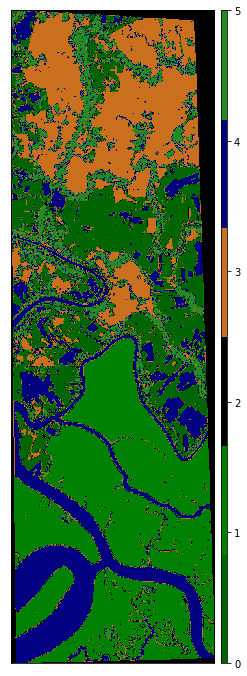

In [85]:
#Loading true data (from the .mat file), the annotated data
y_data = loadmat('Sundarbands_gt.mat')['gt']
print(y_data.shape)

(unique, counts) = np.unique(y_data, return_counts=True)

#names for the different areas
ep.plot_bands(y_data, cmap=ListedColormap(['darkgreen', 'green', 'black', '#CA6F1E', 'navy', 'forestgreen']))
plt.show()

In [86]:
# Splitting the X_scaled data set into training and testing (70% / 30%)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_data.ravel(), test_size=0.30, stratify = y_data.ravel())

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

X_train Shape: (199004, 12)
X_test Shape: (85288, 12)
y_train Shape: (199004,)
y_test Shape:(85288,)


Feature: 0, Score: 0.04495
Feature: 1, Score: 0.08388
Feature: 2, Score: 0.05626
Feature: 3, Score: 0.12752
Feature: 4, Score: 0.06959
Feature: 5, Score: 0.09846
Feature: 6, Score: 0.08986
Feature: 7, Score: 0.05212
Feature: 8, Score: 0.03425
Feature: 9, Score: 0.07977
Feature: 10, Score: 0.13053
Feature: 11, Score: 0.13280


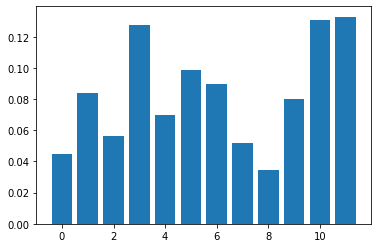

In [88]:
# Using Random Forest to classify

from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
model = RandomForestClassifier()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

RF = model.predict(X_test) # the accuracy of the classification

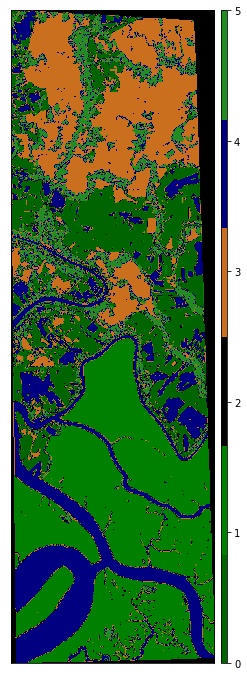

Accuracy: 98.99751430447425
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     16222
           1       1.00      1.00      1.00     23570
           2       1.00      1.00      1.00      6095
           3       0.99      0.99      0.99     16790
           4       0.99      0.99      0.99     13545
           5       0.97      0.97      0.97      9066

    accuracy                           0.99     85288
   macro avg       0.99      0.99      0.99     85288
weighted avg       0.99      0.99      0.99     85288



In [89]:
#show the classified data image
ep.plot_bands(model.predict(X_scaled).reshape((954, 298)), 
              cmap=ListedColormap(['darkgreen', 'green', 'black', 
                                   '#CA6F1E', 'navy', 'forestgreen']))
plt.show()


#print(f"Accuracy: {accuracy_score(y_test, model.predict(X_scaled))*100}")
print(f"Accuracy: {accuracy_score(y_test, RF)*100}")

print(classification_report(y_test, RF))